# Directional Wave Spectrum from NDBC Buoys

Some NDBC buoys measure the full directional wave spectrum. 
A directional wave spectrum $S(f,\theta)$ contains the sea elevation information over all different directions. 
This can be used, for instance, to (1) reconstruct a sea surface elevation time-history over some area (as opposed to at just one point), or (2) to calculate the effect of wave loads on a non-axissymetric structure. 
It is constructed from the omnidirectional spectrum $S(f)$ and a spread function $D(f, \theta)$ as

$$
S(f, \theta) = S(f)D(f, \theta).
$$ 

NDBC stores this information in 5 parameters, each stored in a different file. One parameter (`swden`) is simply the omnidirectional spectrum, while the other 4 (`swdir`, `swdir2`, `swr1`, `swr2`) are used to reconstruct the spread function. For more information on the the parameters and reconstruction see the *Spectral Wave Data* section in [this NDBC site](https://www.ndbc.noaa.gov/measdes.shtml).

In this example we will: 
* check if a specific buoy has directional information and request that data
* reconstruct and plot the directional wave spectrum $S(f, \theta)$
* take a deeper look at the omnidirectional spectrum $S(f)$ and spread function $D(f, \theta)$ separately
* calculate and plot the energy spectrum

We use functions from both the `wave.io.ndbc` and `wave.graphics` submodules. We start by importing `numpy` and MHKiT's `wave` module. 

In [43]:
import numpy as np
from mhkit import wave
import xarray as xr
import matplotlib.pyplot as plt

import os
os.environ['no_proxy'] = '*'

## Request Data
First, we will check if the buoy we're interested in–42012—has directional data. To do this we use the `wave.io.ndbc.available_data` function with any one of the 4 parameters used for the spread function. 
We can see that this buoy does have directional data for the years 2009-2021.

In [44]:
buoy = "42012"
wave.io.ndbc.available_data("swdir", buoy)

,id,year,filename
362,42012,2009,42012d2009.txt.gz
363,42012,2010,42012d2010.txt.gz
364,42012,2011,42012d2011.txt.gz
365,42012,2012,42012d2012.txt.gz
366,42012,2013,42012d2013.txt.gz
367,42012,2014,42012d2014.txt.gz
368,42012,2015,42012d2015.txt.gz
369,42012,2016,42012d2016.txt.gz
370,42012,2017,42012d2017.txt.gz
371,42012,2018,42012d2018.txt.gz


We will ask for the data for 2021. To do this we use the `wave.io.ndbc.request_directional_data` function. We see that the spectrum is calculated over ~1hour which results in 8572 different timestamps. We also see there are 47 frequency bins.

In [45]:
year = 2021
data_all = wave.io.ndbc.request_directional_data(buoy, year)
data_all

<xarray.Dataset>
Dimensions:    (date: 8572, frequency: 47)
Coordinates:
  * date       (date) datetime64[ns] 2021-01-01T00:40:00 ... 2021-12-31T23:40:00
  * frequency  (frequency) float64 0.02 0.0325 0.0375 ... 0.445 0.465 0.485
Data variables:
    swden      (date, frequency) float64 0.0 0.0 0.0 0.0 ... 0.01 0.01 0.02 0.0
    swdir      (date, frequency) float64 194.0 13.0 6.0 ... 173.0 167.0 159.0
    swdir2     (date, frequency) float64 191.0 11.0 9.0 ... 178.0 169.0 106.0
    swr1       (date, frequency) float64 0.16 0.26 0.21 0.41 ... 0.76 0.87 0.63
    swr2       (date, frequency) float64 0.99 0.93 0.9 0.84 ... 0.28 0.67 0.1

## Elevation Variance Spectrum
We now use the data we requested and reconstruct the directional elevation variance spectrum. 
The first step is to decide on the resolution of wave direction. Here we calculate the spectrum every 2 degrees. 
For the reconstruction we use the `wave.io.ndbc.create_directional_spectrum` function.
You can see the spectrum has the correct shape of 47 frequencies x 180 directions, and the units are indicated in the attributes.

[ 0.41054749  0.36167375  0.51516829  0.52605634  0.42368687  0.47647932
 -0.01873325 -0.10569272 -0.1018001  -0.10537748 -0.04972259  0.04689939
  0.00154241 -0.09365348 -0.00385461 -0.04579829 -0.06030135  0.0582082
 -0.04824016 -0.01723582 -0.01080616 -0.02894839 -0.10829981 -0.13045389
 -0.14314154 -0.13272469 -0.02513892 -0.01475832 -0.0389303  -0.062396
 -0.08876044 -0.10362714 -0.0819314  -0.12304341 -0.11764182 -0.03223273
  0.03133878 -0.05756206 -0.00376385 -0.00240581  0.00694174  0.09499671
  0.05211561  0.01847735  0.00738376  0.05051719  0.02265904]
[0.1788568  0.15657529 0.26935029 0.281501   0.20474086 0.23391465
 0.12634603 0.10605063 0.1087268  0.08807741 0.08457373 0.09561445
 0.09097838 0.09882061 0.13198668 0.08981998 0.08139364 0.11430885
 0.07453623 0.06369281 0.07386917 0.05568724 0.03614363 0.03608398
 0.04662742 0.05988454 0.11900253 0.10303546 0.0815047  0.07541638
 0.04701176 0.07631448 0.05538963 0.07220105 0.05705404 0.10783709
 0.10935998 0.08221473 0.080

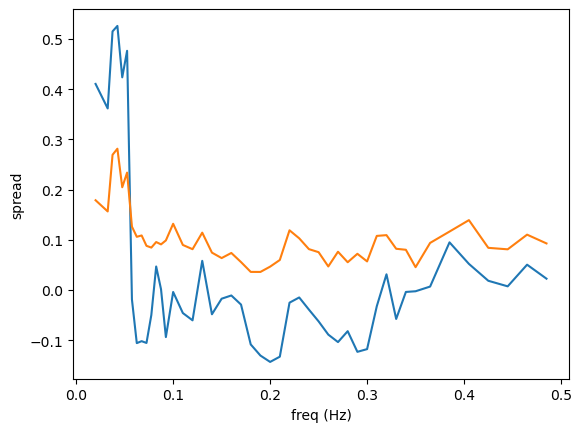

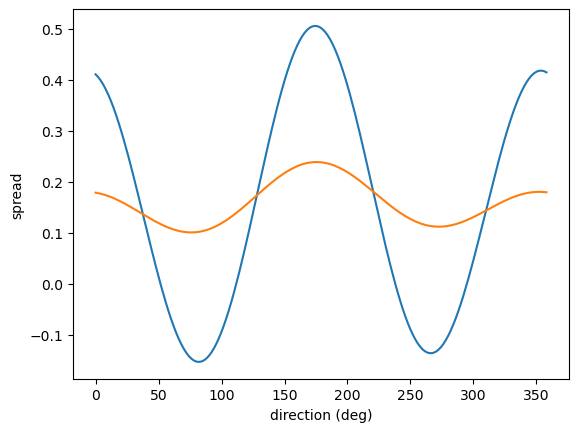

In [46]:
date = np.datetime64("2021-02-21T12:40:00")
data = data_all.sel(date=date)
directions = np.arange(0, 360, 2.0)
# spread manually with weighting values to prevent negative values
r1 = data["swr1"].data.reshape(-1, 1)
r2 = data["swr2"].data.reshape(-1, 1)
a1 = data["swdir"].data.reshape(-1, 1)
a2 = data["swdir2"].data.reshape(-1, 1)
a = directions.reshape(1, -1)
spread = (
    1
    / np.pi
    * (0.5 + r1 * np.cos(np.deg2rad(a - a1)) + r2 * np.cos(2 * np.deg2rad(a - a2)))
)

spread_no_negs = (
    1
    / np.pi
    * (0.5 + (2/3)*r1 * np.cos(np.deg2rad(a - a1)) + (1/6)*r2 * np.cos(2 * np.deg2rad(a - a2)))
)

np.set_printoptions(threshold=np.Inf)

print(spread[:,0])

print(spread_no_negs[:,0])

plt.figure()
plt.plot(data.frequency.values,spread[:,0])
plt.plot(data.frequency.values,spread_no_negs[:,0])
plt.xlabel('freq (Hz)')
plt.ylabel('spread')

plt.figure()
plt.plot(directions,spread[0,:])
plt.plot(directions,spread_no_negs[0,:])
plt.xlabel('direction (deg)')
plt.ylabel('spread')

direction_attrs = {
    "units": "deg",
    "long_name": "wave direction",
    "standard_name": "direction",
}

frequency_attrs = {
    "units": "Hz",
    "long_name": "frequency",
    "standard_name": "f",
}

spread_xr_no_neg = xr.DataArray(spread_no_negs,
    coords={
        "frequency": ("frequency", data.frequency.values, frequency_attrs),
        "direction": ("direction", directions, direction_attrs),
    },
    attrs={
        "units": "(1/Hz/deg)",
        "long_name": "IEC spread",
        "standard_name": "spectrum",
        "description": "spread as a function of frequency and direction",
    },
)

In [47]:
date = np.datetime64("2021-02-21T12:40:00")
data = data_all.sel(date=date)
directions = np.arange(0, 360, 2.0)
omnidirectional_spectrum = data["swden"].data.reshape(-1, 1) # S(f)
spread = wave.io.ndbc.create_spread_function(data, directions).values # D(f,theta)

print(wave.io.ndbc.create_spread_function(data, directions))
print(data["swden"])

#print(omnidirectional_spectrum)
#print(spread)
#print(np.shape(spread))

direction_attrs = {
    "units": "deg",
    "long_name": "wave direction",
    "standard_name": "direction",
}

frequency_attrs = {
    "units": "Hz",
    "long_name": "frequency",
    "standard_name": "f",
}

print(np.shape(omnidirectional_spectrum))
omnidirectional_spectrum = np.squeeze(omnidirectional_spectrum)

omnidirectional_spectrum_xr = xr.DataArray(np.squeeze(omnidirectional_spectrum),
    coords={
        "frequency": ("frequency", data.frequency.values, frequency_attrs),
    },
    attrs={
        "units": "(m^2/Hz)",
        "long_name": "omnidirectional spectrum",
        "standard_name": "spectrum",
        "description": "omnidirectional spectrum as a function of frequency",
    },
)

spread_xr = xr.DataArray(spread,
    coords={
        "frequency": ("frequency", data.frequency.values, frequency_attrs),
        "direction": ("direction", directions, direction_attrs),
    },
    attrs={
        "units": "(1/Hz/deg)",
        "long_name": "IEC spread",
        "standard_name": "spectrum",
        "description": "spread as a function of frequency and direction",
    },
)

omnidirectional_spectrum_xr.to_netcdf('omnidirectional_spectrum.nc')
spread_xr.to_netcdf('spread.nc')

<xarray.DataArray (frequency: 47, direction: 180)>
array([[ 4.10547485e-01,  4.05332778e-01,  3.98756125e-01,
         3.90849369e-01,  3.81651032e-01,  3.71206124e-01,
         3.59565930e-01,  3.46787752e-01,  3.32934635e-01,
         3.18075058e-01,  3.02282597e-01,  2.85635565e-01,
         2.68216632e-01,  2.50112416e-01,  2.31413065e-01,
         2.12211807e-01,  1.92604502e-01,  1.72689164e-01,
         1.52565489e-01,  1.32334357e-01,  1.12097344e-01,
         9.19562210e-02,  7.20124541e-02,  5.23667057e-02,
         3.31183411e-02,  1.43649390e-02, -3.79818811e-03,
        -2.12784633e-02, -3.79865012e-02, -5.38365484e-02,
        -6.87469067e-02, -8.26403369e-02, -9.54444400e-02,
        -1.07092016e-01, -1.17521398e-01, -1.26676757e-01,
        -1.34508381e-01, -1.40972924e-01, -1.46033622e-01,
        -1.49660478e-01, -1.51830420e-01, -1.52527411e-01,
        -1.51742543e-01, -1.49474080e-01, -1.45727478e-01,
        -1.40515361e-01, -1.33857470e-01, -1.25780574e-01,
     

In [48]:
date = np.datetime64("2021-02-21T12:40:00")
data = data_all.sel(date=date)
directions = np.arange(0, 360, 2.0)
#spectrum = wave.io.ndbc.create_directional_spectrum(data, directions)
spectrum = omnidirectional_spectrum_xr * spread_xr_no_neg
spectrum = xr.DataArray(spectrum,
    coords={
        "frequency": ("frequency", data.frequency.values, frequency_attrs),
        "direction": ("direction", directions, direction_attrs),
    },
    attrs={
        "units": "(m^2/Hz/deg)",
        "long_name": "IEC spectrum",
        "standard_name": "spectrum",
        "description": "spectrum as a function of frequency and direction",
    },
)
spectrum = spectrum.rename('spectrum')
print(spectrum)

#spectrum.to_netcdf('full_dir_spectrum.nc')


<xarray.DataArray 'spectrum' (frequency: 47, direction: 180)>
array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
  

We finally plot the spectrum using the `wave.graphics.plot_directional_spectrum` function. Notice that there are negative values, which is due to NDBC's analysis approach which results in negative values far from the mean direction. From [this NDBC site](https://www.ndbc.noaa.gov/measdes.shtml): 
> $D(f,\theta)$ can take on negative values because of the trigonometric sine and cosine functions. There are several approaches to prevent or deal with the negative values. For more information and discussion of some approaches see: Use of advanced directional wave spectra analysis methods, M. D. Earle, K. E. Steele, and D. W. C. Wang, Ocean Engineering, Volume 26, Issue 12, December 1999, Pages 1421-1434.

<PolarAxes: title={'center': 'Elevation Variance Spectrum'}>

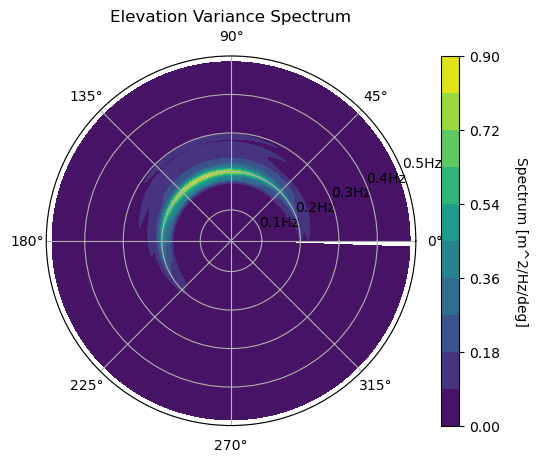

In [49]:
wave.graphics.plot_directional_spectrum(spectrum)

We now show a few other ways of plotting this directional spectra. 
In the first plot below we set a minimum value of $0.3m^2/Hz$. 
In the second plot, we plot 3 contour lines with no fill. 

<PolarAxes: title={'center': 'Elevation Variance Spectrum'}>

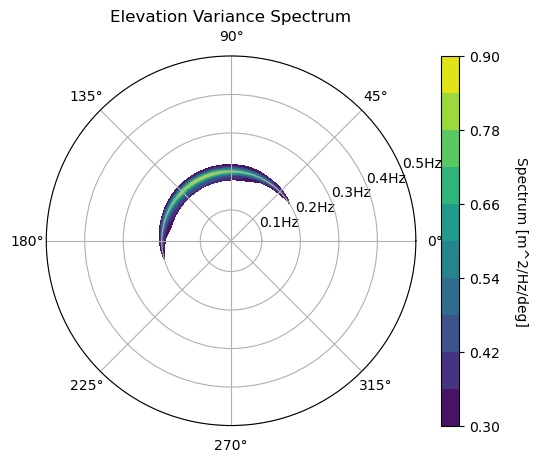

In [50]:
wave.graphics.plot_directional_spectrum(spectrum, color_level_min=0.3)

<PolarAxes: title={'center': 'Elevation Variance Spectrum'}>

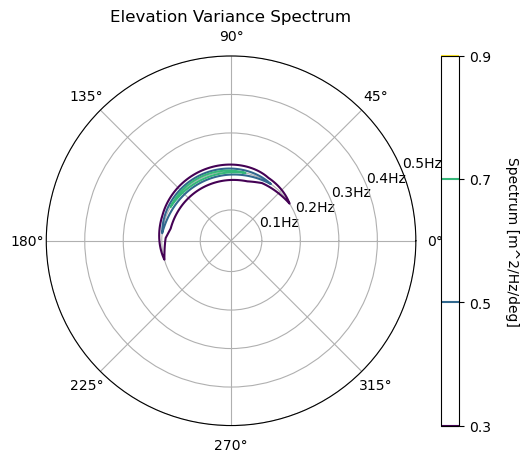

In [51]:
wave.graphics.plot_directional_spectrum(
    spectrum, color_level_min=0.3, fill=False, nlevels=4
)

## Components
In this section we will look plot both the omnidirectional spectrum $S(f)$ and the spread function $D(f, \theta)$ separately. Remember that the spectrum above was given by $S(f)D(f, \theta)$.

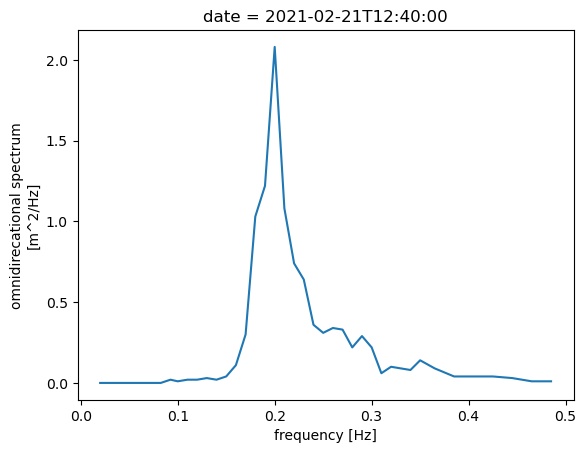

In [52]:
data["swden"].plot()

<PolarAxes: title={'center': 'Spread Spectrum'}>

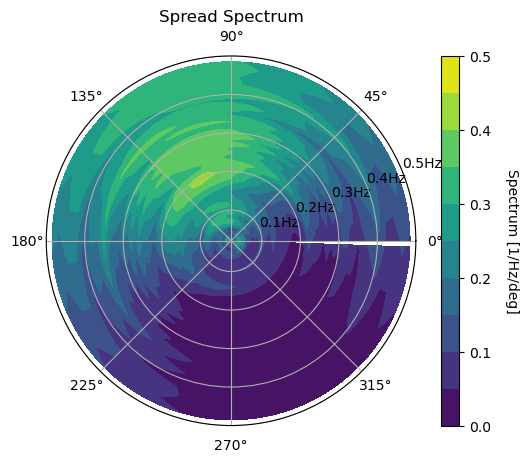

In [55]:
spread = wave.io.ndbc.create_spread_function(data, directions)
wave.graphics.plot_directional_spectrum(spread_xr_no_neg, name="Spread", units="1")

## Energy Spectrum
Finally, we show how to calculate and plot other spectra. 
Here we show the energy spectrum, which is proportional to the elevation variance spectrum with a proportionality constant of $\rho g$. That is, $S_E(f, \theta) = \rho g S(f, \theta)$. We provide the plotting function additional information so that it displays the correct name and units. 

<PolarAxes: title={'center': 'Energy Spectrum'}>

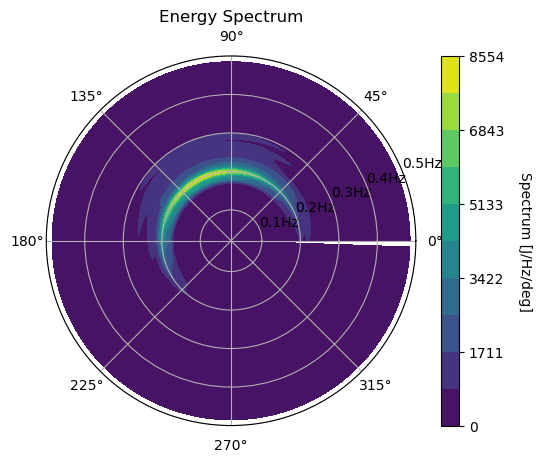

In [54]:
rho = 1025  # kg/m^3
g = 9.81  # m/s^2
wave.graphics.plot_directional_spectrum(spectrum * rho * g, name="Energy", units="J")